<a href="https://colab.research.google.com/github/Nehaasati/AgenticRag/blob/main/flightprice_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [7]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [12]:
train_data = pd.read_excel(r"/content/sample_data/Data_Train (1).xlsx")

In [13]:
pd.set_option('display.max_columns', None)

In [14]:
train_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [15]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [16]:
train_data["Duration"].value_counts()

,count
Duration,
2h 50m,550
1h 30m,386
2h 55m,337
2h 45m,337
2h 35m,329
...,...
37h 10m,1
32h 20m,1
40h 20m,1


In [17]:
train_data.dropna(inplace = True)

In [18]:
train_data.isnull().sum()

,0
Airline,0
Date_of_Journey,0
Source,0
Destination,0
Route,0
Dep_Time,0
Arrival_Time,0
Duration,0
Total_Stops,0
Additional_Info,0


In [19]:
train_data["Journey_day"] = pd.to_datetime(train_data.Date_of_Journey, format="%d/%m/%Y").dt.day

In [20]:
train_data["Journey_month"] = pd.to_datetime(train_data["Date_of_Journey"], format = "%d/%m/%Y").dt.month

In [21]:
# Since we have converted Date_of_Journey column into integers, Now we can drop as it is of no use.

train_data.drop(["Date_of_Journey"], axis = 1, inplace = True)

In [22]:
 #Departure time is when a plane leaves the gate.
# Similar to Date_of_Journey we can extract values from Dep_Time

# Extracting Hours
train_data["Dep_hour"] = pd.to_datetime(train_data["Dep_Time"]).dt.hour

# Extracting Minutes
train_data["Dep_min"] = pd.to_datetime(train_data["Dep_Time"]).dt.minute

# Now we can drop Dep_Time as it is of no use
train_data.drop(["Dep_Time"], axis = 1, inplace = True)

/tmp/ipython-input-3988379867.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_data["Dep_hour"] = pd.to_datetime(train_data["Dep_Time"]).dt.hour
/tmp/ipython-input-3988379867.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_data["Dep_min"] = pd.to_datetime(train_data["Dep_Time"]).dt.minute


In [23]:
# Arrival time is when the plane pulls up to the gate.
# Similar to Date_of_Journey we can extract values from Arrival_Time

# Extracting Hours
train_data["Arrival_hour"] = pd.to_datetime(train_data.Arrival_Time).dt.hour

# Extracting Minutes
train_data["Arrival_min"] = pd.to_datetime(train_data.Arrival_Time).dt.minute

# Now we can drop Arrival_Time as it is of no use
train_data.drop(["Arrival_Time"], axis = 1, inplace = True)

/tmp/ipython-input-1117634591.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_data["Arrival_hour"] = pd.to_datetime(train_data.Arrival_Time).dt.hour
/tmp/ipython-input-1117634591.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_data["Arrival_min"] = pd.to_datetime(train_data.Arrival_Time).dt.minute


In [24]:
# Time taken by plane to reach destination is called Duration
# It is the differnce betwwen Departure Time and Arrival time


# Assigning and converting Duration column into list
duration = list(train_data["Duration"])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:    # Check if duration contains only hour or mins
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"   # Adds 0 minute
        else:
            duration[i] = "0h " + duration[i]           # Adds 0 hour

duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))    # Extract hours from duration
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))   # Extracts only minutes from duration

In [25]:
train_data["Duration_hours"] = duration_hours
train_data["Duration_mins"] = duration_mins

In [26]:
train_data.drop(["Duration"], axis = 1, inplace = True)

In [27]:
train_data["Airline"].value_counts()

,count
Airline,
Jet Airways,3849
IndiGo,2053
Air India,1751
Multiple carriers,1196
SpiceJet,818
Vistara,479
Air Asia,319
GoAir,194
Multiple carriers Premium economy,13


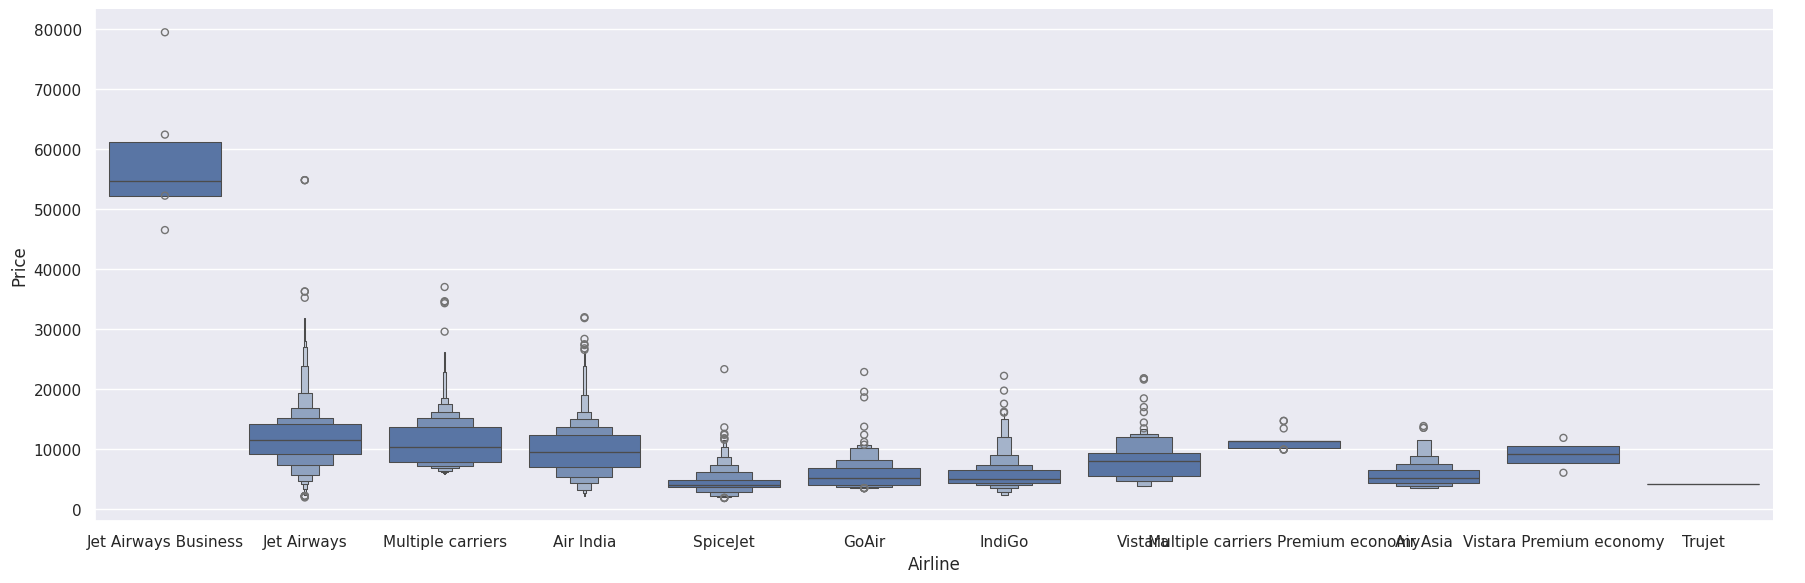

In [28]:
# Airline vs Price
sns.catplot(y = "Price", x = "Airline", data = train_data.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.show()

In [29]:
Airline = train_data[["Airline"]]

Airline = pd.get_dummies(Airline, drop_first= True)

Airline.head()

,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy
0,False,False,True,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,False
2,False,False,False,True,False,False,False,False,False,False,False
3,False,False,True,False,False,False,False,False,False,False,False
4,False,False,True,False,False,False,False,False,False,False,False


In [30]:
Source = train_data[["Source"]]

Source = pd.get_dummies(Source, drop_first= True)

Source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,False,False,False,False
1,False,False,True,False
2,False,True,False,False
3,False,False,True,False
4,False,False,False,False


In [31]:
Destination = train_data[["Destination"]]

Destination = pd.get_dummies(Destination, drop_first = True)

Destination.head()

,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,False,False,False,False,True
1,False,False,False,False,False
2,True,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,True


In [32]:
train_data["Total_Stops"].value_counts()

,count
Total_Stops,
1 stop,5625
non-stop,3491
2 stops,1520
3 stops,45
4 stops,1


In [33]:
train_data["Route"]

,Route
0,BLR → DEL
1,CCU → IXR → BBI → BLR
2,DEL → LKO → BOM → COK
3,CCU → NAG → BLR
4,BLR → NAG → DEL
...,...
10678,CCU → BLR
10679,CCU → BLR
10680,BLR → DEL
10681,BLR → DEL


In [34]:
# Additional_Info contains almost 80% no_info
# Route and Total_Stops are related to each other

train_data.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

In [35]:
train_data["Total_Stops"].value_counts()

,count
Total_Stops,
1 stop,5625
non-stop,3491
2 stops,1520
3 stops,45
4 stops,1


In [36]:
# As this is case of Ordinal Categorical type we perform LabelEncoder
# Here Values are assigned with corresponding keys

train_data.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)

/tmp/ipython-input-1758178131.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)


In [37]:
# Concatenate dataframe --> train_data + Airline + Source + Destination

data_train = pd.concat([train_data, Airline, Source, Destination], axis = 1)

In [38]:
data_train.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)

In [39]:
data_train.head()

,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,3897,24,3,22,20,1,10,2,50,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1,2,7662,1,5,5,50,13,15,7,25,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
2,2,13882,9,6,9,25,4,25,19,0,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False
3,1,6218,12,5,18,5,23,30,5,25,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
4,1,13302,1,3,16,50,21,35,4,45,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


In [41]:
test_data = pd.read_excel(r"/content/sample_data/Test_set (1).xlsx")

In [42]:
test_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [43]:
print("Null values :")
print("-"*75)
test_data.dropna(inplace = True)
print(test_data.isnull().sum())

# EDA

# Date_of_Journey
test_data["Journey_day"] = pd.to_datetime(test_data.Date_of_Journey, format="%d/%m/%Y").dt.day
test_data["Journey_month"] = pd.to_datetime(test_data["Date_of_Journey"], format = "%d/%m/%Y").dt.month
test_data.drop(["Date_of_Journey"], axis = 1, inplace = True)

# Dep_Time
test_data["Dep_hour"] = pd.to_datetime(test_data["Dep_Time"]).dt.hour
test_data["Dep_min"] = pd.to_datetime(test_data["Dep_Time"]).dt.minute
test_data.drop(["Dep_Time"], axis = 1, inplace = True)

# Arrival_Time
test_data["Arrival_hour"] = pd.to_datetime(test_data.Arrival_Time).dt.hour
test_data["Arrival_min"] = pd.to_datetime(test_data.Arrival_Time).dt.minute
test_data.drop(["Arrival_Time"], axis = 1, inplace = True)

# Duration
duration = list(test_data["Duration"])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:    # Check if duration contains only hour or mins
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"   # Adds 0 minute
        else:
            duration[i] = "0h " + duration[i]           # Adds 0 hour

duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))    # Extract hours from duration
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))   # Extracts only minutes from duration

# Adding Duration column to test set
test_data["Duration_hours"] = duration_hours
test_data["Duration_mins"] = duration_mins
test_data.drop(["Duration"], axis = 1, inplace = True)


# Categorical data

print("Airline")
print("-"*75)
print(test_data["Airline"].value_counts())
Airline = pd.get_dummies(test_data["Airline"], drop_first= True)

print()

print("Source")
print("-"*75)
print(test_data["Source"].value_counts())
Source = pd.get_dummies(test_data["Source"], drop_first= True)

print()

print("Destination")
print("-"*75)
print(test_data["Destination"].value_counts())
Destination = pd.get_dummies(test_data["Destination"], drop_first = True)

# Additional_Info contains almost 80% no_info
# Route and Total_Stops are related to each other
test_data.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

# Replacing Total_Stops
test_data.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)

# Concatenate dataframe --> test_data + Airline + Source + Destination
data_test = pd.concat([test_data, Airline, Source, Destination], axis = 1)

data_test.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)

print()
print()

print("Shape of test data : ", data_test.shape)

Null values :
---------------------------------------------------------------------------
Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
dtype: int64
Airline
---------------------------------------------------------------------------
Airline
Jet Airways                          897
IndiGo                               511
Air India                            440
Multiple carriers                    347
SpiceJet                             208
Vistara                              129
Air Asia                              86
GoAir                                 46
Multiple carriers Premium economy      3
Vistara Premium economy                2
Jet Airways Business                   2
Name: count, dtype: int64

Source
---------------------------------------------------------------------------
Source
Delhi       1145
Kolkata   

/tmp/ipython-input-587351420.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test_data["Dep_hour"] = pd.to_datetime(test_data["Dep_Time"]).dt.hour
/tmp/ipython-input-587351420.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test_data["Dep_min"] = pd.to_datetime(test_data["Dep_Time"]).dt.minute
/tmp/ipython-input-587351420.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test_data["Arrival_hour"] = pd.to_datetime(test_data.Arrival_Time).dt.hour
/tmp/ipython-input-587351420.py:20: UserWarning: Could not infer format, so each element will be parsed individually, 

In [44]:
data_test.head()


,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Vistara,Vistara Premium economy,Chennai,Delhi,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata,New Delhi
0,1,6,6,17,30,4,25,10,55,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False
1,1,12,5,6,20,10,20,4,0,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
2,1,21,5,19,15,19,0,23,45,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False
3,1,21,5,8,0,21,0,13,0,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False
4,0,24,6,23,55,2,45,2,50,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


In [45]:
data_train.shape
data_train.columns

Index(['Total_Stops', 'Price', 'Journey_day', 'Journey_month', 'Dep_hour',
       'Dep_min', 'Arrival_hour', 'Arrival_min', 'Duration_hours',
       'Duration_mins', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Destination_New Delhi'],
      dtype='object')

In [49]:
X = data_train.loc[:, ['Total_Stops', 'Journey_day', 'Journey_month', 'Dep_hour',
       'Dep_min', 'Arrival_hour', 'Arrival_min', 'Duration_hours',
       'Duration_mins', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Destination_New Delhi']]
X.head()

,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,24,3,22,20,1,10,2,50,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1,2,1,5,5,50,13,15,7,25,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
2,2,9,6,9,25,4,25,19,0,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False
3,1,12,5,18,5,23,30,5,25,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
4,1,1,3,16,50,21,35,4,45,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


In [50]:
y = data_train.iloc[:, 1]
y.head()

,Price
0,3897
1,7662
2,13882
3,6218
4,13302


In [51]:
# Important feature using ExtraTreesRegressor

from sklearn.ensemble import ExtraTreesRegressor
selection = ExtraTreesRegressor()
selection.fit(X, y)

ExtraTreesRegressor()

In [52]:
print(selection.feature_importances_)

[2.39848293e-01 1.43727880e-01 5.38600662e-02 2.38742765e-02
 2.16532810e-02 2.77595946e-02 1.94410750e-02 1.16002011e-01
 1.77805326e-02 9.33289927e-03 1.59745287e-03 1.75475730e-02
 1.36823494e-01 6.68592555e-02 1.86504378e-02 9.13749896e-04
 2.99683962e-03 1.09893663e-04 5.26594268e-03 7.33838758e-05
 4.27082410e-04 1.05042836e-02 3.03204135e-03 5.36953888e-03
 9.78534581e-03 1.32016695e-02 8.28303167e-03 5.01739437e-04
 2.47773359e-02]


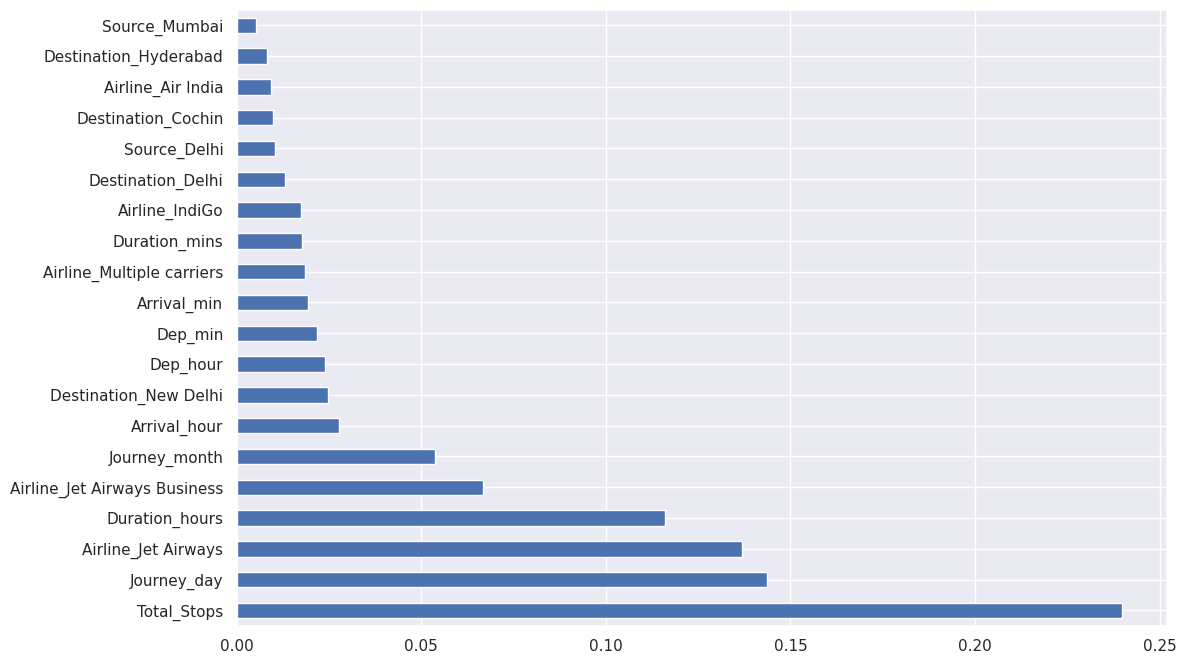

In [53]:
plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [55]:
from sklearn.ensemble import RandomForestRegressor
reg_rf = RandomForestRegressor()
reg_rf.fit(X_train, y_train)

RandomForestRegressor()

In [56]:
y_pred = reg_rf.predict(X_test)

In [57]:
reg_rf.score(X_train, y_train)

0.9532509568993346

In [58]:
reg_rf.score(X_test, y_test)

0.7958127962773196

/tmp/ipython-input-3453123835.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-y_pred)


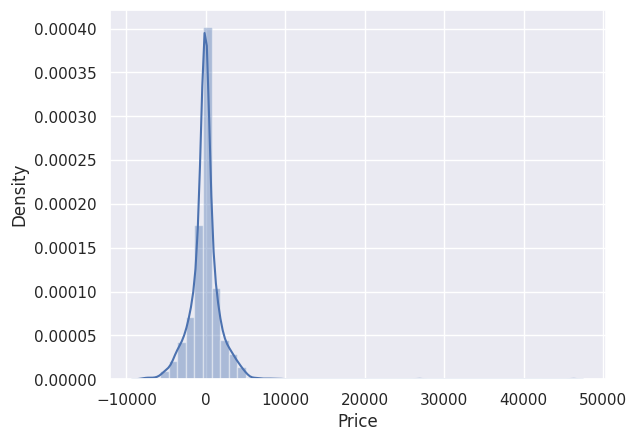

In [59]:
sns.distplot(y_test-y_pred)
plt.show()

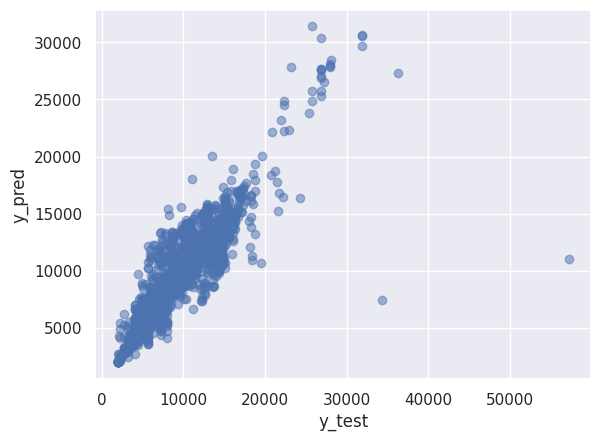

In [54]:
plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [60]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 1179.9609227421959
MSE: 4402695.987341532
RMSE: 2098.2602286993697


In [61]:
2090.5509/(max(y)-min(y))
metrics.r2_score(y_test, y_pred)

0.7958127962773196

In [62]:
from sklearn.model_selection import RandomizedSearchCV

In [63]:
#Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

In [64]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [65]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# Random search of parameters, using 5 fold cross validation,
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = reg_rf, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [68]:
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   3.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   4.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   3.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   3.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   3.9s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   6.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   5.5s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimator

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [69]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 25}

In [70]:
prediction = rf_random.predict(X_test)

/tmp/ipython-input-375150797.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-prediction)


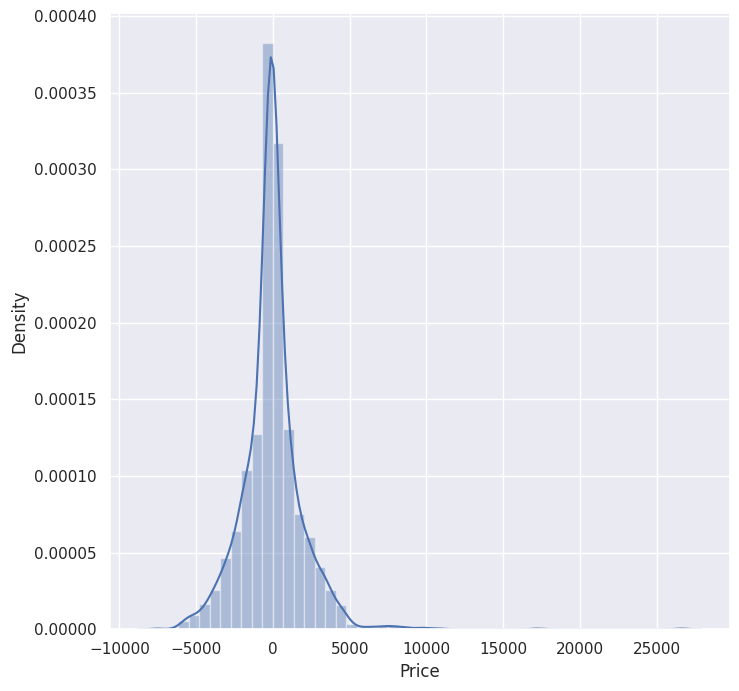

In [71]:
plt.figure(figsize = (8,8))
sns.distplot(y_test-prediction)
plt.show()

In [72]:
print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

MAE: 1260.9700648682942
MSE: 3858786.8779053176
RMSE: 1964.3795147336773


In [73]:
import pickle
# open a file, where you ant to store the data
file = open('flight_rf.pkl', 'wb')

# dump information to that file
pickle.dump(reg_rf, file)

In [74]:
model = open('flight_rf.pkl','rb')
forest = pickle.load(model)

In [75]:
y_prediction = forest.predict(X_test)

In [76]:
metrics.r2_score(y_test, y_prediction)

0.7958127962773196